In [96]:
# import basic libraries
import os
import json
import sys
import huggingface_hub
import numpy as np
import pandas as pd
import re
import random
import torch
import requests
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from collections import Counter
import plotly.io as pio
import pyperclip
from sklearn.cluster import KMeans
import importlib.util
from pathlib import Path
from collections import Counter

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

In [2]:
from sentence_transformers import SentenceTransformer
sentence_model = SentenceTransformer('sentence-transformers/LaBSE')


2025-06-30 22:31:06.794748: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-30 22:31:06.932465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751315466.991148  505444 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751315467.008164  505444 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751315467.119908  505444 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [53]:
labyrinthus_df = pd.read_csv("../data/labyrinthus_grela.csv")
labyrinthus_df.head(5)


,Unnamed: 0,sentence_id,grela_id,token_text,lemma,pos_tag,char_start,char_end,sentence_text,sentence_position,...,title_short,emlap_noscemus_id,place_publication,place_geonames,author_viaf,title_viaf,date_random,context_3sents,concordance,target_token
0,0,noscemus_607725_23015,noscemus_607725,Labyrinthum,labyrinthus,PROPN,35.0,46.0,"Fotamen ad secundam cauernam, siue Labyrinthum...",23015.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1627.0,Nerui optici portio. | Fotamen ad secundam cau...,"Fotamen ad secundam cauernam , siue Labyrinthu...",Labyrinthum
1,1,noscemus_732034_21345,noscemus_732034,labyrintho,labyrinthus,NOUN,83.0,93.0,Um operi huic summa cura insistenti complures ...,21345.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1665.0,Praefatio. | Um operi huic summa cura insisten...,Um operi huic summa cura insistenti complures ...,labyrintho
2,2,noscemus_928135_286,noscemus_928135,labyrinthos,labyrinthus,NOUN,115.0,126.0,"In hac tamen parte, quae motus locales partium...",286.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1609.0,eo quoque rationum robore in muniendis suis de...,"In hac tamen parte , quae motus locales partiu...",labyrinthos
3,3,noscemus_732630_8837,noscemus_732630,Labyrintho,labyrinthus,PROPN,86.0,96.0,"Scio tamen eum in Logicis aliquid scripsisse, ...",8837.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1668.0,"An aliquid recens publico dederit, mer latet, ...","Scio tamen eum in Logicis aliquid scripsisse ,...",Labyrintho
4,4,emlap_100045_1368,emlap_100045,labyrinthum,labyrinthus,NOUN,176.0,187.0,Sed postquam hominum sapiendi per seipsos uanu...,1368.0,...,De naturae luce physica,NaN,Frankfurt,NaN,NaN,NaN,1583.0,"Dubium non est, quin Deus antiquis patribus me...",Sed postquam hominum sapiendi per seipsos uanu...,labyrinthum


In [68]:
SYSTEM = """
You are a Latin philologist and semantic analyst. You are classifying how the word 'labyrinthus' is used in context.

Respond with a single lowercase label (1–2 words, no punctuation) that best describes the semantic sense of the term:

""".strip()

FEWSHOT = """
Passage:
Labyrinthum erroris intexat.
Label: error

Passage:
In quo quicunque notitiam aliquam Trinitatis ... labyrinthum diuinae reuelationis ingreditur.
Label: theological

Passage:
Unde praemonendum puto ... ne quis irrationabili aestimet voluptate ... labyrinthum erroris intexat.
Label: metaphor

Passage:
inter corticem et lignum, Habitat in truncis Pini, ubi labyrinthos format ...
Label: natural

Passage:
Jauditoria Arteria Interna ... in labyrinthi cauitatem intrat ...
Label: anatomical

Passage:
{0}
Label:
""".strip()

def classify_labyrinthus(passage):
    # Handle NaN or None values
    if pd.isna(passage) or passage is None:
        return "unknown"

    # Ensure passage is a string
    passage = str(passage)

    url = "http://localhost:11434/api/generate"
    prompt = FEWSHOT.format(passage.strip())
    payload = {
        "model": "llama3.1:70b",
        "system": SYSTEM,
        "prompt": prompt,
        "options": {
            "temperature": 0,
            "num_predict": 5
        },
        "stream": False
    }
    response = requests.post(url, json=payload)
    if response.status_code == 200:
        return response.json()["response"].strip().lower()
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None


classify_labyrinthus(labyrinthus_df.sample()["context_3sents"].iloc[0])

'metaphorical'

In [69]:
%%time
from concurrent.futures import ThreadPoolExecutor, as_completed

def classify_many(passages, max_workers=30):
    results = [None]*len(passages)
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        fut_to_i = {ex.submit(classify_labyrinthus, p): i
                    for i, p in enumerate(passages)}
        for fut in as_completed(fut_to_i):
            i = fut_to_i[fut]
            results[i] = fut.result()
    return results

labyrinthus_df["classification"] = classify_many(labyrinthus_df["context_3sents"])


CPU times: user 2.79 s, sys: 1.3 s, total: 4.1 s
Wall time: 1h 9min 13s


In [85]:
labyrinthus_df["classification"].value_counts()[:20]

classification
anatomical         208
mythological       162
architectural      105
metaphorical        67
philosophical       30
astronomical        30
literary            25
alchemical          24
metaphor            24
unknown             23
medical             19
figurative          18
methodological      18
rhetorical          16
epistemological     15
theological         13
spiritual           13
geographical        10
administrative       8
artistic             8
Name: count, dtype: int64

In [72]:
labyrinthus_df.to_parquet("../data/labyrinthus_df_classified.parquet")

In [79]:
labyrinthus_df_clean = labyrinthus_df[["sentence_id", "classification"]].drop_duplicates(subset=['sentence_id'], keep='first')

In [80]:
len(labyrinthus_df_clean)

925

In [77]:
labyrinthus_merged = pd.read_csv("../data/labyrinthus_grela.csv")
len(labyrinthus_merged)

979

In [82]:
labyrinthus_merged = pd.merge(labyrinthus_merged, labyrinthus_df_clean, on="sentence_id", how="left")

In [83]:
labyrinthus_merged.to_csv("../data/labyrinthus_classified.csv", index=False)

In [87]:
top_20_labels = labyrinthus_merged['classification'].value_counts().head(20).index.tolist()

In [88]:
filtered_data = labyrinthus_merged[labyrinthus_merged['classification'].isin(top_20_labels)]

In [98]:
time_bins = np.arange(-200, 1800, 200)
colors = sns.color_palette("tab20", 20)  # 20 distinct colors
# 100-year bins from 500 BCE to 1700 CE

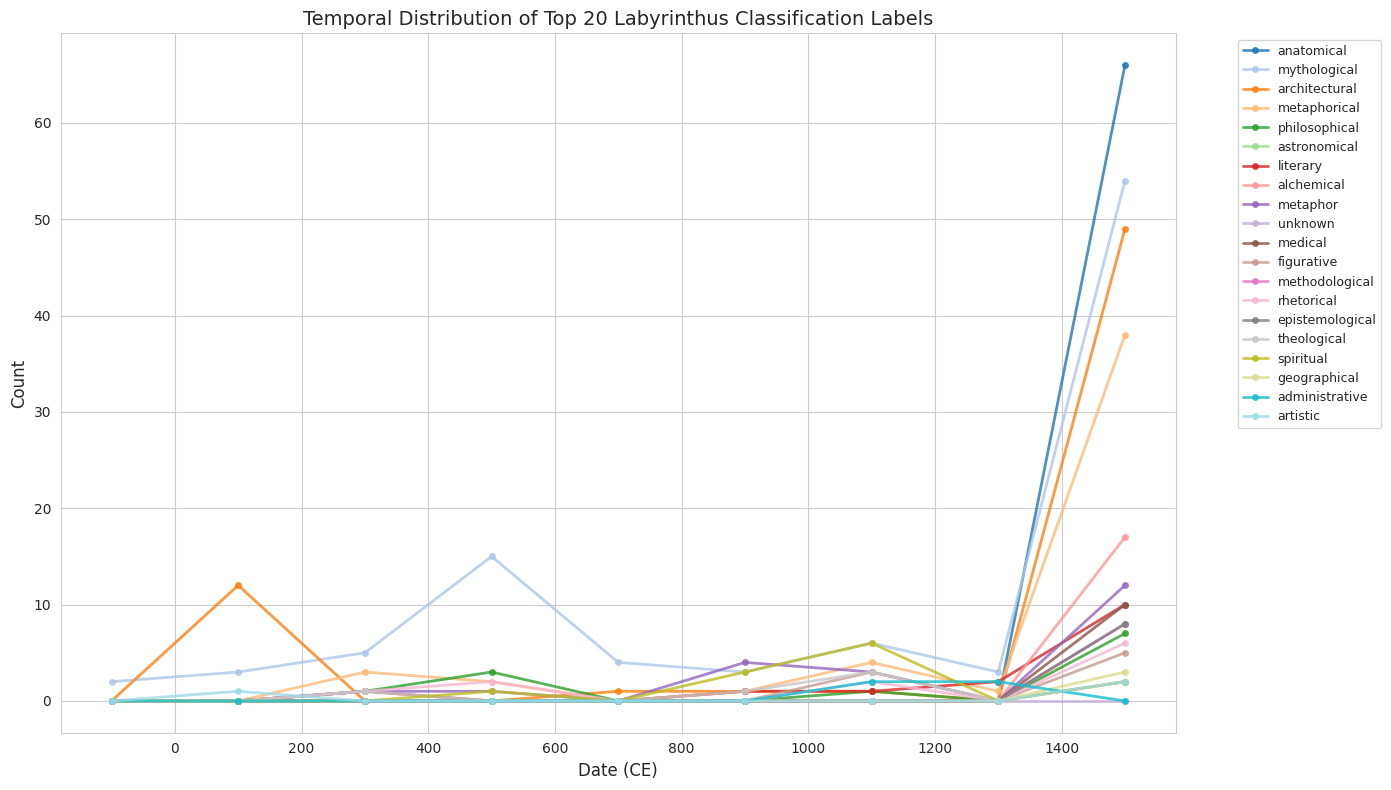

In [99]:
fig, ax = plt.subplots(figsize=(14, 8))

# Plot histogram for each classification label
for i, label in enumerate(top_20_labels):
    label_data = filtered_data[filtered_data['classification'] == label]['date_random']
    counts, _ = np.histogram(label_data, bins=time_bins)
    bin_centers = (time_bins[:-1] + time_bins[1:]) / 2

    ax.plot(bin_centers, counts, label=label, color=colors[i],
            marker='o', markersize=4, linewidth=2, alpha=0.8)

ax.set_xlabel('Date (CE)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Temporal Distribution of Top 20 Labyrinthus Classification Labels', fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()


In [100]:
fig.savefig("../figures/labyrinthus_classifications_temp_dist.png", dpi=300)

In [86]:
labyrinthus_merged.columns

Index(['Unnamed: 0', 'sentence_id', 'grela_id', 'token_text', 'lemma',
       'pos_tag', 'char_start', 'char_end', 'sentence_text',
       'sentence_position', 'grela_source', 'grela_id_1', 'author', 'title',
       'not_before', 'not_after', 'lagt_tlg_epithet', 'lagt_genre',
       'lagt_provenience', 'noscemus_place', 'noscemus_genre',
       'noscemus_discipline', 'title_short', 'emlap_noscemus_id',
       'place_publication', 'place_geonames', 'author_viaf', 'title_viaf',
       'date_random', 'context_3sents', 'concordance', 'target_token',
       'classification'],
      dtype='object')

In [ ]:
labyrinthus_me

In [ ]:
from transfrmers import AutoTokenizer, AutoModel
import torch

# 1️⃣  Model name for XLM-RoBERTa-base
model_id = "xlm-roberta-base"

# 2️⃣  Load tokenizer & model
tokenizer = AutoTokenizer.from_pretrained(model_id)
model     = AutoModel.from_pretrained(model_id)

# 3️⃣  Encode a Latin sentence
sentence = "Quid faciamus homines miserrimi et novi generis labyrintho inclusi?"
encoded  = tokenizer(
    sentence,
    return_tensors="pt",
    return_attention_mask=True,
    add_special_tokens=True
)

# 4️⃣  Get contextual token embeddings
with torch.no_grad():
    output = model(**encoded)
    token_embeddings = output.last_hidden_state.squeeze(0)   # shape: [seq_len, 768]

# ── Example: map embeddings back to tokens ──────────────────────────────
tokens = tokenizer.convert_ids_to_tokens(encoded["input_ids"][0])
for tok, vec in zip(tokens, token_embeddings):
    print(f"{tok:12} → {vec[:5]} …")   # show first 5 dims as a sanity check